In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score


from sys import stdout

In [2]:
# functions of interest
def prediction(X_train, y_train, X_test, y_test, plot_components=False):

    #Run PLS including a variable number of components, up to 40,  and calculate MSE
    mse = []
    component = np.arange(1, np.max(X.shape[1])+1) # set max nb of components to nb of variables
    for i in component:
        pls = PLSRegression(n_components=i)
        # Fit
        pls.fit(X_train, y_train)
        # Prediction
        Y_pred = pls.predict(X_test)

        mse_p = mean_squared_error(y_test, Y_pred)
        mse.append(mse_p)

        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")

    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(xmin=-1)

        plt.show()

    # Run PLS with suggested number of components
    pls = PLSRegression(n_components=msemin+1)
    pls.fit(X_train, y_train)
    Y_pred = pls.predict(X_test) 
    
    # Calculate and print scores
    score_p = r2_score(y_test, Y_pred)
    mse_p = mean_squared_error(y_test, Y_pred)
    sep = np.std(Y_pred[:,0]-y_test)
    rpd = np.std(y_test)/sep
    bias = np.mean(Y_pred[:,0]-y_test)
    
    print('R2: %5.3f'  % score_p)
    print('MSE: %5.3f' % mse_p)
    print('SEP: %5.3f' % sep)
    print('RPD: %5.3f' % rpd)
    print('Bias: %5.3f' %  bias)

    # Plot regression and figures of merit
    rangey = max(y_test) - min(y_test)
    rangex = max(Y_pred) - min(Y_pred)

    z = np.polyfit(y_test, Y_pred, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(Y_pred, y_test, c='red', edgecolors='k')
        ax.plot(z[1]+z[0]*y_test, y_test, c='blue', linewidth=1)
        ax.plot(y_test, y_test, color='green', linewidth=1)
        plt.xlabel('Predicted')
        plt.ylabel('Measured')
        plt.title('Prediction')

        # Print the scores on the plot
        plt.text(min(Y_pred)+0.05*rangex, max(y_test)-0.1*rangey, 'R$^{2}=$ %5.3f'  % score_p)
        plt.text(min(Y_pred)+0.05*rangex, max(y_test)-0.15*rangey, 'MSE: %5.3f' % mse_p)
        plt.text(min(Y_pred)+0.05*rangex, max(y_test)-0.2*rangey, 'SEP: %5.3f' % sep)
        plt.text(min(Y_pred)+0.05*rangex, max(y_test)-0.25*rangey, 'RPD: %5.3f' % rpd)
        plt.text(min(Y_pred)+0.05*rangex, max(y_test)-0.3*rangey, 'Bias: %5.3f' %  bias)
        plt.show()    

# PLSR

In [3]:
# PLS regression, with univariate response, a.k.a. PLS1
n = 1000
p = 10
X = np.random.normal(size=n * p).reshape((n, p))
y = X[:, 0] + 2 * X[:, 1] + np.random.normal(size=n * 1) + 5

In [4]:
pls1 = PLSRegression(n_components=10)
pls1.fit(X, y)
# note that the number of compements exceeds 1 (the dimension of y)
print("Estimated betas")
print(np.round(pls1.coef_, 2))

Estimated betas
[[ 0.96]
 [ 1.95]
 [ 0.04]
 [ 0.06]
 [ 0.01]
 [-0.01]
 [ 0.01]
 [ 0.05]
 [-0.06]
 [-0.03]]


## Cross-validation

In [5]:
# creates a train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=45)

In [6]:
print("This are the dimensions of X_train:",X_train.shape)
print("And this is how it looks")
X_train[1:5,1:5]

This are the dimensions of X_train: (750, 10)
And this is how it looks


array([[-0.48508533, -1.36726442,  0.48420054, -0.20250997],
       [-0.4240064 ,  0.45212009, -0.08316828,  0.78963963],
       [-0.32333168, -0.72960722,  0.94045185, -0.88548908],
       [-0.34876437,  1.72078259,  0.51223012,  1.17454026]])

In [7]:
X_test.shape

(250, 10)

In [8]:
y_train.shape

(750,)

In [9]:
y_test.shape

(250,)

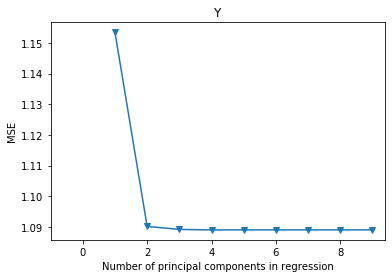

In [10]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 10):
    pls = PLSRegression(n_components=i,scale=True)
    score = model_selection.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 10), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Y')
plt.xlim(xmin=-1)
plt.show()

The last plot shows that 2 components are enough to minimise the Mean Squared Error.
We will thus initialise a PLS model with only two components

In [11]:
# fit a PLS regression model with two components
pls = PLSRegression(n_components=2,scale=True)
pls.fit(X_train,y_train)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

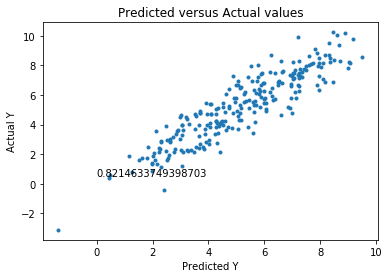

In [12]:
# shows how well the model predicts Y values
y_pred = pls.predict(X_test)
plt.scatter(y_pred,y_test,marker=".")
plt.xlabel("Predicted Y")
plt.ylabel("Actual Y")
plt.title("Predicted versus Actual values")


# calculate R2 score
score = r2_score(y_test, y_pred)
plt.text(0,0.5,score)
plt.show()

In [13]:
# Calculate scores
mse = mean_squared_error(y_test, y_pred)
print("R2 score:",score)
print("MSE:",mse)

R2 score: 0.8214633749398703
MSE: 0.9426149447734589


This functions first runs a loop over the number of PLS components (up to number of variables) and calculate the MSE of prediction.  Second it finds the number of components that minimises the MSE ans uses that value to run PLS again. The second time a whole bunch of metrics is calculated and printed. 

27% completed
Suggested number of components:  2



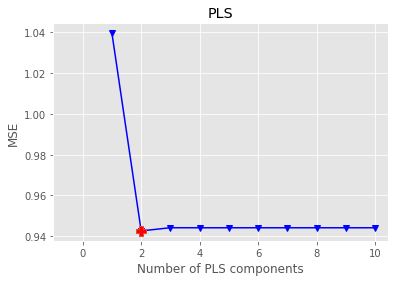

R2: 0.821
MSE: 0.943
SEP: 0.968
RPD: 2.375
Bias: -0.080


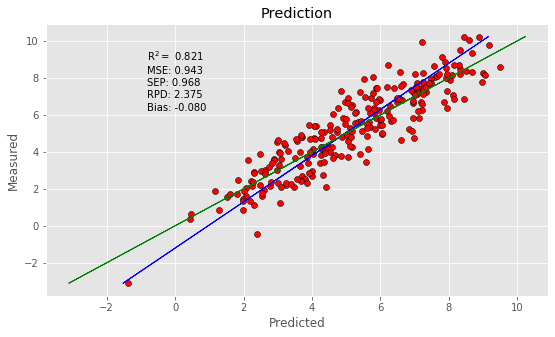

In [14]:
# plot
prediction(X_train=X_train,
           y_train=y_train,
           X_test=X_test,
           y_test=y_test,
           plot_components=True)